Import necessary libraries

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Load and Preprocess Data

In [23]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/gh_food_nutritional_values.csv')

In [24]:
# Standardize food names
df['Food'] = df['Food'].str.strip().str.lower()

In [25]:
df.head()

,Food,Water(g),Protein(g),Fat(g),Carbs(g),SFA(100g),MUFA(100g),PUFA(100g),Calories(100g),Category
0,hausa koko,93.8,0.5,0.4,5.3,0.0,0.0,0.0,26.8,Carbohydrate
1,koko,93.8,0.5,0.4,5.3,0.0,0.0,0.0,26.8,Carbohydrate
2,akpler,66.6,1.4,0.8,31.2,0.0,0.0,0.0,137.6,Carbohydrate
3,banku,70.6,2.7,1.3,25.4,0.0,0.0,0.0,124.1,Carbohydrate
4,ga kenkey,64.2,3.6,1.7,30.5,0.0,0.0,0.0,151.7,Carbohydrate


In [26]:
df.columns

Index(['Food', 'Water(g)', 'Protein(g)', 'Fat(g)', 'Carbs(g)', 'SFA(100g)',
       'MUFA(100g)', 'PUFA(100g)', 'Calories(100g)', 'Category'],
      dtype='object')

In [4]:
# Fill missing values in nutritional columns
nutritional_columns = ['Protein(g)', 'Fat(g)', 'Carbs(g)', 'Calories(100g)',
                       'Water(g)', 'SFA(100g)', 'MUFA(100g)', 'PUFA(100g)']
df[nutritional_columns] = df[nutritional_columns].fillna(df[nutritional_columns].mean())


In [5]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(df[nutritional_columns])


The Autoencoder Model

In [6]:
class FoodAutoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=16):
        super(FoodAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


Train the model

In [7]:
# Prepare training data
X_tensor = torch.tensor(X, dtype=torch.float32)

In [8]:
# Initialize model, optimizer, and loss function
model = FoodAutoencoder(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    embeddings, outputs = model(X_tensor)
    loss = criterion(outputs, X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 100/1000, Loss: 0.185282
Epoch 200/1000, Loss: 0.052708
Epoch 300/1000, Loss: 0.010878
Epoch 400/1000, Loss: 0.004583
Epoch 500/1000, Loss: 0.002330
Epoch 600/1000, Loss: 0.001606
Epoch 700/1000, Loss: 0.001233
Epoch 800/1000, Loss: 0.000990
Epoch 900/1000, Loss: 0.000793
Epoch 1000/1000, Loss: 0.000654


Save Food Embeddings

In [10]:
with torch.no_grad():
    food_embeddings = model.encoder(X_tensor).numpy()


Visualize Embeddings

<ipython-input-27-6b96880d9149>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', n_clusters)


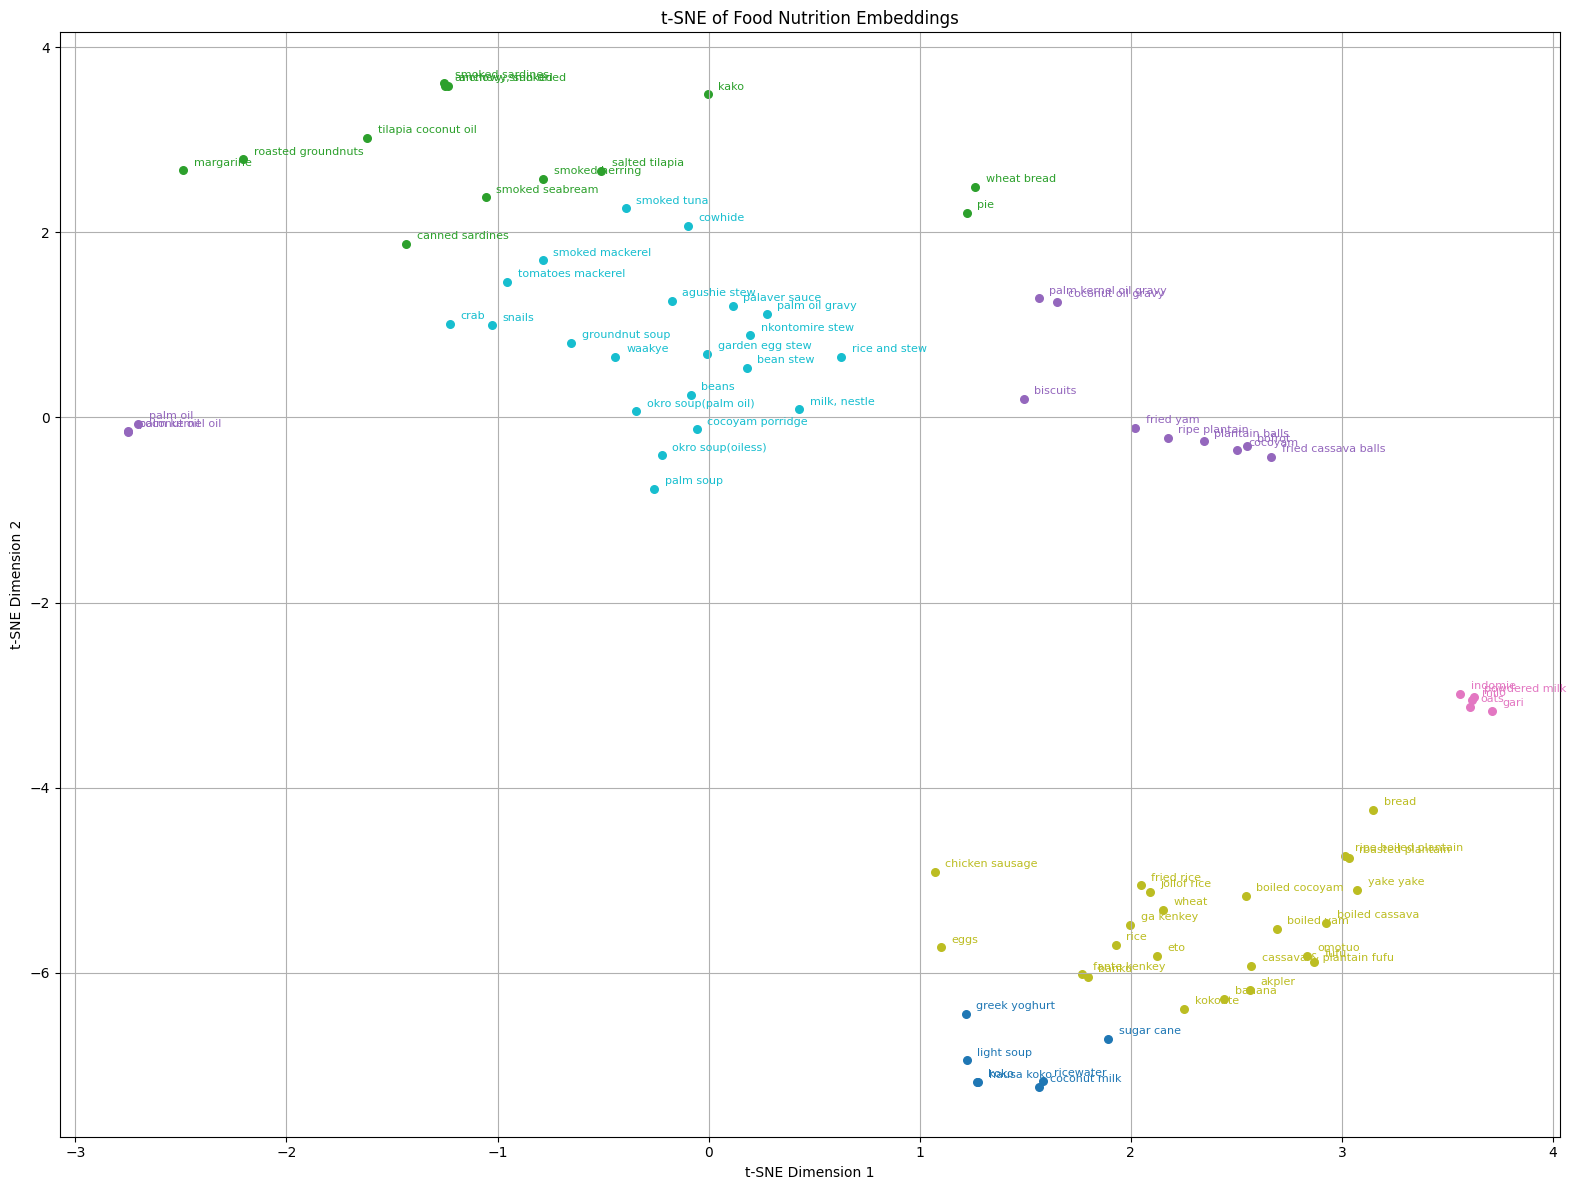

In [27]:
# Apply KMeans to group similar foods
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(food_embeddings)

# Project embeddings into 2D space with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(food_embeddings)

# Use color map to differentiate clusters
colors = cm.get_cmap('tab10', n_clusters)

# Plot
plt.figure(figsize=(16, 12))
for i in range(len(X_tsne)):
    x, y = X_tsne[i]
    cluster_id = labels[i]
    plt.scatter(x, y, color=colors(cluster_id), s=30)
    plt.text(x + 0.05, y + 0.05, df['Food'].iloc[i], fontsize=8, color=colors(cluster_id))

plt.title("t-SNE of Food Nutrition Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


Cosine Similarity Evaluation

In [12]:
def evaluate_similarity(df, embeddings, top_n=5):
    similarities = []
    for idx in range(len(df)):
        vec = embeddings[idx].reshape(1, -1)
        sims = cosine_similarity(vec, embeddings).flatten()
        top_indices = sims.argsort()[::-1][1:top_n+1]
        avg_sim = np.mean(sims[top_indices])
        similarities.append(avg_sim)
    return np.mean(similarities)

avg_similarity = evaluate_similarity(df, food_embeddings)
print(f"Average Top-{5} Cosine Similarity: {avg_similarity:.4f}")


Average Top-5 Cosine Similarity: 0.9420


Loss Report

In [13]:
print(f"Final Reconstruction Loss (MSE): {criterion(outputs, X_tensor).item():.6f}")

Final Reconstruction Loss (MSE): 0.000654
